<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/ARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Batch Prediction System with Full Process Flow
import logging
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
import yaml
import json
from typing import Dict, Any, Optional
import hashlib
import mlflow

class BatchPredictionPipeline:
    def __init__(self, config_path: str):
        self.start_time = datetime.now()
        self.config = self._load_config(config_path)
        self.setup_logging()
        self.batch_id = self._generate_batch_id()

    def _load_config(self, config_path: str) -> Dict[str, Any]:
        """Load and validate configuration settings."""
        with open(config_path) as f:
            config = yaml.safe_load(f)
        # Validate required configuration elements
        required_keys = ['model_path', 'input_path', 'output_path', 'log_path']
        if not all(key in config for key in required_keys):
            raise ValueError("Missing required configuration keys")
        return config

    def setup_logging(self):
        """Configure logging with batch ID and timestamps."""
        log_path = Path(self.config['log_path'])
        log_path.mkdir(parents=True, exist_ok=True)

        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - BatchID:%(batch_id)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_path / f'batch_{self.batch_id}.log'),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
        self.logger.addHandler(logging.FileHandler(log_path / 'all_batches.log'))

    def _generate_batch_id(self) -> str:
        """Generate unique batch ID based on timestamp and config hash."""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        config_hash = hashlib.md5(str(self.config).encode()).hexdigest()[:6]
        return f"{timestamp}_{config_hash}"

    def pre_execution_checks(self) -> bool:
        """Perform all necessary checks before batch execution."""
        try:
            self.logger.info("Starting pre-execution checks")

            # Check input data existence and accessibility
            input_path = Path(self.config['input_path'])
            if not input_path.exists():
                raise FileNotFoundError(f"Input path {input_path} not found")

            # Check model accessibility
            model_path = Path(self.config['model_path'])
            if not model_path.exists():
                raise FileNotFoundError(f"Model file {model_path} not found")

            # Check output directory writeable
            output_path = Path(self.config['output_path'])
            output_path.mkdir(parents=True, exist_ok=True)
            test_file = output_path / 'test_write.tmp'
            try:
                test_file.touch()
                test_file.unlink()
            except Exception as e:
                raise PermissionError(f"Cannot write to output directory: {str(e)}")

            # Check system resources
            self._check_system_resources()

            # Validate input data schema
            self._validate_input_schema()

            self.logger.info("All pre-execution checks passed")
            return True

        except Exception as e:
            self.logger.error(f"Pre-execution checks failed: {str(e)}")
            raise

    def execute_batch(self):
        """Execute the batch prediction process."""
        try:
            self.logger.info(f"Starting batch prediction for batch {self.batch_id}")

            # Load model and data
            model = self._load_model()
            data = self._load_data()

            # Record metadata
            self._record_batch_metadata(data)

            # Process in chunks
            chunk_size = self.config.get('chunk_size', 10000)
            predictions = []

            for chunk_idx, chunk in enumerate(self._chunk_generator(data, chunk_size)):
                self.logger.info(f"Processing chunk {chunk_idx + 1}")
                chunk_predictions = self._process_chunk(model, chunk)
                predictions.extend(chunk_predictions)

                # Record progress
                self._update_progress(chunk_idx, len(data) // chunk_size)

            # Save results and metadata
            self._save_results(predictions, data)

            # Perform post-execution validation
            self._validate_results(predictions)

            self.logger.info(f"Batch prediction completed successfully")

        except Exception as e:
            self.logger.error(f"Batch execution failed: {str(e)}")
            self._handle_failure(e)
            raise

    def _record_batch_metadata(self, data: pd.DataFrame):
        """Record metadata about the batch execution."""
        metadata = {
            'batch_id': self.batch_id,
            'start_time': self.start_time.isoformat(),
            'input_rows': len(data),
            'model_version': self._get_model_version(),
            'config_snapshot': self.config,
            'input_schema': data.dtypes.to_dict(),
            'system_info': self._get_system_info()
        }

        metadata_path = Path(self.config['log_path']) / 'batch_metadata'
        metadata_path.mkdir(parents=True, exist_ok=True)

        with open(metadata_path / f'{self.batch_id}.json', 'w') as f:
            json.dump(metadata, f, indent=2)

    def _validate_results(self, predictions: list):
        """Validate the prediction results."""
        # Check for expected number of predictions
        # Check prediction value ranges
        # Check for unexpected nulls
        # Log validation results
        pass

    def generate_batch_report(self):
        """Generate comprehensive report of the batch execution."""
        end_time = datetime.now()
        duration = end_time - self.start_time

        report = {
            'batch_summary': {
                'batch_id': self.batch_id,
                'start_time': self.start_time.isoformat(),
                'end_time': end_time.isoformat(),
                'duration_seconds': duration.total_seconds(),
                'records_processed': self.total_records,
                'success_rate': self.success_rate
            },
            'performance_metrics': self._calculate_performance_metrics(),
            'error_summary': self._generate_error_summary(),
            'data_quality_metrics': self._calculate_data_quality_metrics()
        }

        # Save report
        report_path = Path(self.config['log_path']) / 'reports'
        report_path.mkdir(parents=True, exist_ok=True)

        with open(report_path / f'{self.batch_id}_report.json', 'w') as f:
            json.dump(report, f, indent=2)

        return report

# Usage example
if __name__ == "__main__":
    pipeline = BatchPredictionPipeline('config/batch_config.yaml')

    if pipeline.pre_execution_checks():
        pipeline.execute_batch()
        report = pipeline.generate_batch_report()

FileNotFoundError: [Errno 2] No such file or directory: 'config/batch_config.yaml'

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.2 MB/s eta 0:00:00



ARCH Model Results:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -633.633
Distribution:                  Normal   AIC:                           1273.27
Method:            Maximum Likelihood   BIC:                           1287.99
                                        No. Observations:                 1000
Date:                Sat, Dec 07 2024   Df Residuals:                      999
Time:                        18:54:08   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.6809e-03  1.113e-

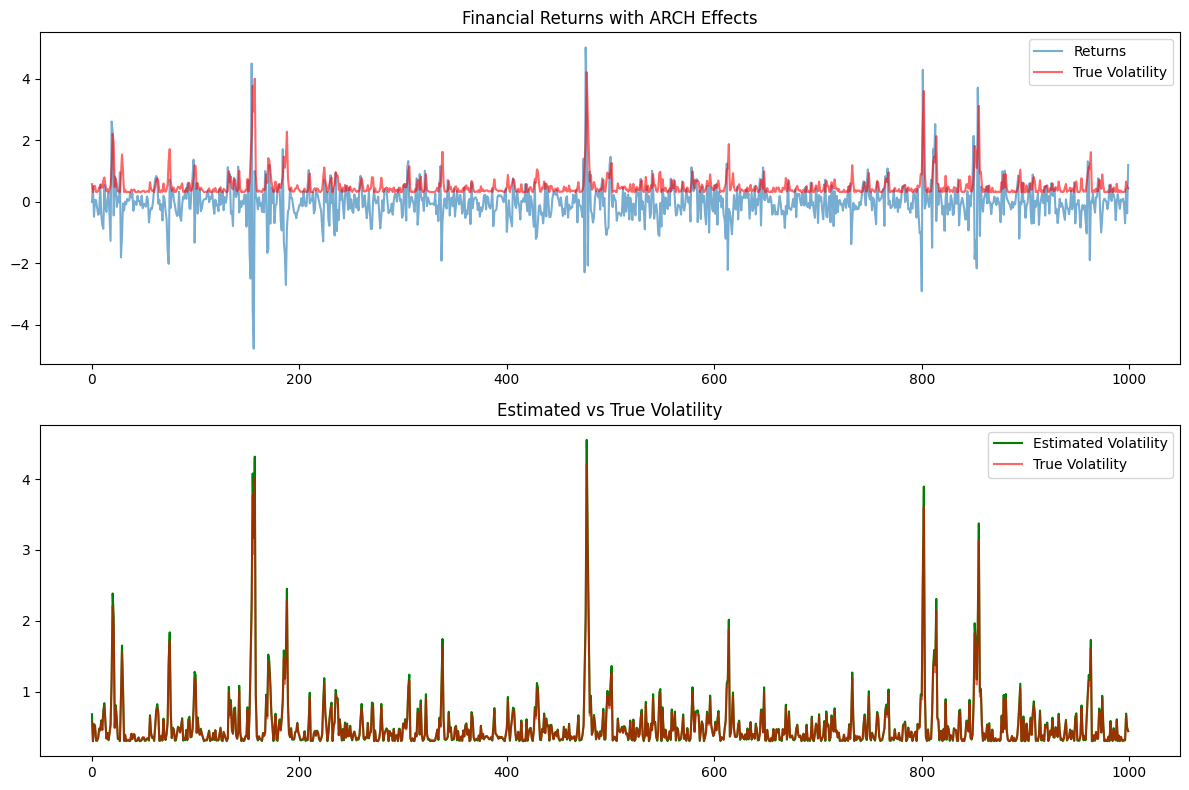

In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Generate synthetic financial returns with ARCH effects
def generate_arch_returns(n_samples=1000, omega=0.1, alpha=0.7):
    """
    Simulate financial returns exhibiting ARCH(1) properties

    Parameters:
    - n_samples: Number of time periods to simulate
    - omega: Base level of volatility (constant term)
    - alpha: How much previous volatility affects current volatility
    """
    # Initialize arrays for returns and volatility
    returns = np.zeros(n_samples)
    sigma2 = np.zeros(n_samples)  # Conditional variance

    # Set initial variance
    sigma2[0] = omega / (1 - alpha)

    # Generate returns with time-varying volatility
    for t in range(1, n_samples):
        # Calculate conditional variance based on previous return
        sigma2[t] = omega + alpha * returns[t-1]**2

        # Generate return with this variance
        returns[t] = np.sqrt(sigma2[t]) * np.random.standard_normal()

    return returns, np.sqrt(sigma2)

# Generate and analyze ARCH returns
returns, volatility = generate_arch_returns()

# Fit an ARCH model to the data
model = arch_model(returns, vol='ARCH', p=1)
results = model.fit(disp='off')

print("\nARCH Model Results:")
print(results.summary())

# Plot returns and estimated volatility
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(returns, label='Returns', alpha=0.6)
plt.plot(volatility, color='red', label='True Volatility', alpha=0.6)
plt.title('Financial Returns with ARCH Effects')
plt.legend()

plt.subplot(212)
plt.plot(results.conditional_volatility,
         label='Estimated Volatility', color='green')
plt.plot(volatility, color='red', label='True Volatility', alpha=0.6)
plt.title('Estimated vs True Volatility')
plt.legend()
plt.tight_layout()